# Settings

In [34]:
# mesh_path = '/home/knpob/file/4-Dataset/20211229-Running breast scanning/3dmd/0kmh_8marker_bra'
mesh_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20211229-Running breast scanning/3dmd/0kmh_8marker_bra'
# mesh_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/mesh'
export_folder = "output"

# Data loading

In [35]:
import os

files = os.listdir(mesh_path)
files = [os.path.join(mesh_path, f.replace('.obj', '')) for f in files if '.obj' in f]
files.sort()

In [38]:
import pyvista as pv
from mesh4d.analyse import crave

mesh = pv.read(files[0] + '.obj')
# mesh = crave.fix_pvmesh_disconnect(mesh)
texture = pv.read_texture(files[0] + '.jpg')

In [39]:
mesh.plot(texture=texture)

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa0611ab3a0_10&reconnect=auto' style='wid…

In [40]:
import numpy as np

def parse_vertex_color(mesh, texture) -> tuple:
    texture_img = np.array(texture.to_array())
    u, v = mesh.active_t_coords.T
    v_mapped = np.round((1 - v) * (texture_img.shape[0] - 1)).astype(int)
    u_mapped = np.round(u * (texture_img.shape[1] - 1)).astype(int)
    
    color_ls = texture_img[v_mapped, u_mapped]
    vertex_ls = np.array(mesh.points)
        
    return color_ls, vertex_ls

In [41]:
color_ls, vertex_ls = parse_vertex_color(mesh, texture)
color_ls, vertex_ls

(array([[149, 123, 108],
        [147, 124, 108],
        [155, 129, 116],
        ...,
        [ 14,   9,  13],
        [  9,  10,  12],
        [  8,  12,  11]], dtype=uint8),
 array([[-236.36734 ,  596.9041  , -158.62914 ],
        [-235.12917 ,  600.85956 , -161.25824 ],
        [-234.20221 ,  596.7676  , -163.55753 ],
        ...,
        [-105.81465 , -328.7931  , -174.14429 ],
        [ -73.567764, -323.46378 , -171.41885 ],
        [ -91.6267  , -297.56808 , -162.62166 ]], dtype=float32))

In [42]:
from scipy.spatial import KDTree

tree = KDTree(vertex_ls)

# Marker extraction

## Gray scale threshold

In [43]:
ds, idx = tree.query(vertex_ls, 10)
respond = np.sum(color_ls * [0.299, 0.587, 0.114], axis=1)
gray_ls = respond

'std 71.41114318312894 mean 84.92212859064327 min 1.288 max 255.0'

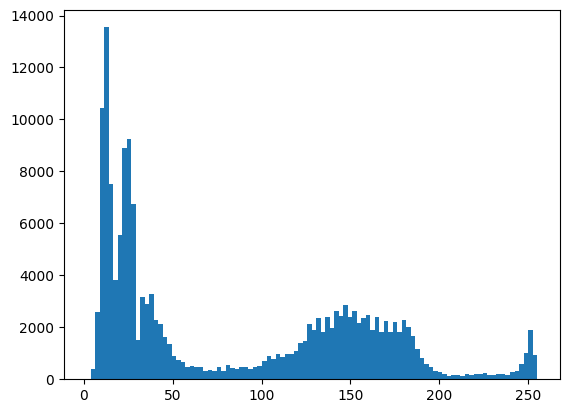

In [44]:
import matplotlib.pyplot as plt

mean = np.mean(respond)
std = np.std(respond)
plt.hist(gray_ls, bins=100)
f"std {np.std(gray_ls)} mean {np.mean(gray_ls)} min {np.min(gray_ls)} max {np.max(gray_ls)}"

In [45]:
mesh.plot(scalars=-respond, cmap='cool')

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa06114f340_11&reconnect=auto' style='wid…

In [46]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[gray_ls < 100])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh, scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa06118a7f0_12&reconnect=auto' style='wid…

## Local gray scale difference

In [47]:
ds, idx = tree.query(vertex_ls, 10)
respond = np.max(np.abs(gray_ls[idx]  - np.expand_dims(gray_ls, axis=-1)), axis=1)

'std 19.554183403829736 mean 8.810173637426901 min 0.0 max 235.582'

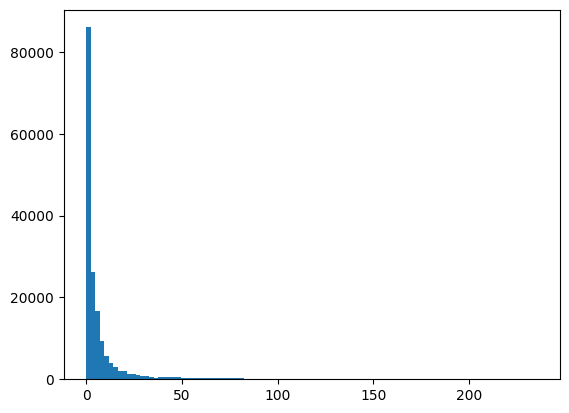

In [48]:
import matplotlib.pyplot as plt

mean = np.mean(respond)
std = np.std(respond)
plt.hist(respond, bins=100)
f"std {np.std(respond)} mean {np.mean(respond)} min {np.min(respond)} max {np.max(respond)}"

In [49]:
mesh.plot(scalars=respond, cmap='cool')

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa0623a9ac0_13&reconnect=auto' style='wid…

In [50]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[respond > mean + 2 * std])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh, scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa0623c0fa0_14&reconnect=auto' style='wid…

## Local gray scale gradients

In [51]:
ds, idx = tree.query(vertex_ls, 100)
respond = np.max(np.abs(gray_ls[idx] - np.expand_dims(gray_ls, -1)) / (ds + 1e-5), axis=1)

'std 613892.2475700108 mean 117879.2039308044 min 0.0 max 22801699.999999996'

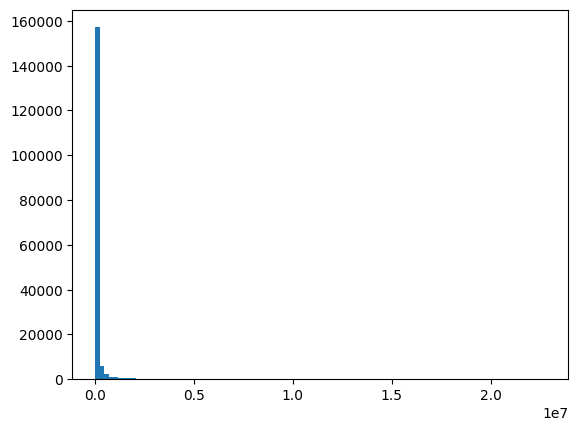

In [52]:
plt.hist(respond, bins=100)
mean = np.mean(respond)
std = np.std(respond)
f"std {np.std(respond)} mean {np.mean(respond)} min {np.min(respond)} max {np.max(respond)}"

In [53]:
mesh.plot(scalars=respond, cmap='cool')

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa0747e2df0_15&reconnect=auto' style='wid…

In [54]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[respond > mean + 2 * std])
scene.add_mesh(cloud, point_size=2, color='goldenrod')
scene.add_mesh(mesh, scalars=gray_ls, cmap='gray')
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:57828/index.html?ui=P_0x7fa091ee6940_16&reconnect=auto' style='wid…

# Batch validation

In [55]:
def extract(mesh, texture, pnum=100, range=2):
    color_ls, vertex_ls = parse_vertex_color(mesh, texture)
    gray_ls = np.sum(color_ls * [0.299, 0.587, 0.114], axis=1)
    
    tree = KDTree(vertex_ls)
    ds, idx = tree.query(vertex_ls, pnum)
    
    respond = np.max(np.abs(gray_ls[idx] - np.expand_dims(gray_ls, -1)) / (ds + 1e-5), axis=1)
    mean = np.mean(respond)
    std = np.std(respond)
    marker_vertex_ls = vertex_ls[respond > mean + range * std]
    # need to address empty issue

    return gray_ls, marker_vertex_ls

In [56]:
from mesh4d import obj3d
from mesh4d.analyse import crave

mesh_ls, texture_ls = obj3d.load_mesh_series(
    folder=mesh_path,
    start=0,
    stride=12,
    end=120,
)

mesh_ls = [crave.fix_pvmesh_disconnect(mesh) for mesh in mesh_ls]

[                    ] 0.8% loading: /Users/knpob/Territory/2-Kolmo/4-Dataset/20211229-Running breast scanning/3dmd/0kmh_8marker_bra/static_standing_with_bra.000001.obj

IndexError: list index out of range

In [33]:
import os
from mesh4d import utils

scene.open_movie(os.path.join(export_folder, 'marker.mp4'), framerate=10)
plot_num = len(mesh_ls)

for idx in range(len(mesh_ls)):
    scene.clear()
    
    gray_ls, marker_vertex_ls = extract(mesh_ls[idx], texture_ls[idx])
    cloud = pv.PolyData(marker_vertex_ls)
    scene.add_mesh(cloud, point_size=2, color='goldenrod')
    scene.add_mesh(mesh_ls[idx], scalars=gray_ls, cmap='gray')

    scene.camera_position = 'xy'
    scene.write_frame()

    percent = (idx + 1) / plot_num
    utils.progress_bar(percent, back_str=" exported the {}-th frame".format(idx))

scene.close()

[=                   ] 9.1% exported the 0-th frame

[swscaler @ 0x7fcdc8008000] Warning: data is not aligned! This can lead to a speed loss


[====================] 100.0% exported the 10-th frame
